In [1]:
# import libraries
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
gd = pd.read_csv("googleplaystore.csv")

In [3]:
%matplotlib inline

In [4]:
# Look at first 5 rows
gd.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
# Checking the data type of the columns
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

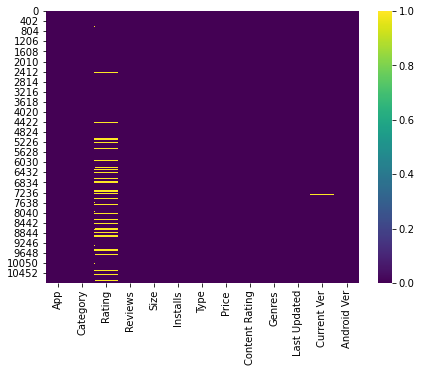

In [6]:
# Exploring missing data, checking to see if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(gd.isnull(), cmap='viridis')
gd.isnull().any()

In [7]:
# Looks like there are missing values in "Rating", "Type", "Content Rating" and " Android Ver" 
# also has some missing values, but most of these missing values in Rating column.
gd.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [8]:
#There are two strategies to handle missing data, either removing records with these missing values or replacing 
#missing values with a specific value like (mean, median or mode) value of the column

# The best way to fill missing values might be using the median instead of mean.
gd['Rating'] = gd['Rating'].fillna(gd['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	gd['Current Ver'] = gd['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))
    
# https://thispointer.com/python-how-to-use-if-else-elif-in-lambda-functions/

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	gd['Current Ver'] = gd['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

gd['Current Ver'] = gd['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1)
                                                        .replace('.', '').replace(',', '.',1)).astype(float)
gd['Current Ver'] = gd['Current Ver'].fillna(gd['Current Ver'].median())

In [9]:
# Count number of unique values in category column 
gd['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [10]:
# Check record  of unreasonable value which is 1.9
i = gd[gd['Category'] == '1.9'].index
gd.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


In [11]:
# Drop bad column
gd = gd.drop(i)

In [12]:
# Removing NaN values
gd = gd[pd.notnull(gd['Last Updated'])]
gd = gd[pd.notnull(gd['Content Rating'])]

In [13]:
# App values encoding
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
gd['App'] = le.fit_transform(gd['App'])
# This encoder converts the values into numeric values

In [14]:
# Category features encoding
category_list = gd['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
#gd = pd.concat([gd, pd.get_dummies(gd['Category'], prefix='cat')], axis=1)

In [15]:
# Genres features encoding
le = preprocessing.LabelEncoder()
gd['Genres'] = le.fit_transform(gd['Genres'])

In [16]:
# Rating features encoding
le = preprocessing.LabelEncoder()
gd['Content Rating'] = le.fit_transform(gd['Content Rating'])

In [17]:
# Type encoding
gd['Type'] = pd.get_dummies(gd['Type'])

In [18]:
# Last Updated encoding
gd['Last Updated'] = gd['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [19]:
# Price cleaning
# gd['Price'] = gd['Price'].apply(lambda x : x.strip('$'))
gd["Price"] = gd["Price"].apply(lambda x: str(x).replace('$','') if '$' in x else x)

In [20]:
# Installs cleaning
# gd['Installs'] = gd['Installs'].apply(lambda x : x.strip('+').replace(',', ''))
gd['Installs'] = gd['Installs'].apply(lambda x: x.replace('+', '') if '+' in x else x)
gd['Installs'] = gd['Installs'].apply(lambda x: x.replace(',', '') if ',' in x else x)
gd['Installs'] = gd['Installs'].apply(lambda x: x.replace('Free', 'NaN') if 'Free' in x else x)
gd['Installs'] = gd['Installs'].apply(lambda x: x.replace('Paid', 'NaN') if 'Paid' in x else x)

In [21]:
# Size cleaning
gd[gd['Size'] == 'Varies with device'] = 0
gd["Size"] = gd["Size"].apply(lambda x: str(x).replace('M','') 
                              if 'M' in str(x) else x)
gd["Size"] = gd["Size"].apply(lambda x: str(x).replace(',','') 
                              if ',' in str(x) else x)
gd['Size'] = gd['Size'].apply(lambda x: str(x).replace('+', '') 
                              if '+' in str(x) else x)
gd['Size'] = gd["Size"].apply(lambda x: float(str(x).replace('k',''))/1024 
                              if 'k' in str(x) else x)
# Convert kbytes to mbytes 

In [22]:
gd['Size'] = gd['Size'].apply(lambda x:float(x))
gd['Installs'] = gd['Installs'].apply(lambda x:int(x))
gd['Reviews'] = gd['Reviews'].apply(lambda x:int(x))
gd['Price'] = gd['Price'].apply(lambda x:float(x))
gd = gd.dropna()

In [23]:
gd.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

In [24]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
# features.extend(category_list)
X = gd[features]
y = gd['Rating']

In [25]:
# Split the dataset into 75% train data and 25% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

### KNeighborsRegressor

In [26]:
# Look at the 15 closest neighbors
model = KNeighborsRegressor(n_neighbors=15)

In [27]:
# Find the mean accuracy of knn regression using X_test and y_test
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [28]:
# Calculate the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 91.73%'

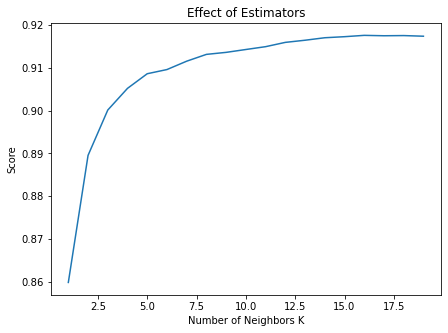

In [29]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

### The RandomForestRegressor

[(10, 0.9244401549584813),
 (20, 0.9286051662153387),
 (30, 0.9293170770289523),
 (40, 0.9316362581129182),
 (50, 0.9293924309031873),
 (60, 0.930388096613961),
 (70, 0.9309400161290049),
 (80, 0.9312411522832729),
 (90, 0.9313116077454939),
 (100, 0.9318299985916734),
 (110, 0.9312840406594435),
 (120, 0.9319545183864312),
 (130, 0.9317630599476296),
 (140, 0.9324614243065356),
 (150, 0.9312976781885105),
 (160, 0.9317302367785011),
 (170, 0.9312936544117438),
 (180, 0.9320276484598153),
 (190, 0.931998342185551)]

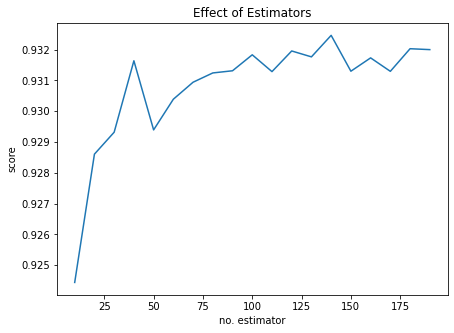

In [30]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [31]:
predictions = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 0.24953000582637427
Mean Squared Error: 0.17444583271151276
Root Mean Squared Error: 0.41766713147135814


In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
data = gd[['Rating', 'Size', 'Installs', 'Reviews', 'Price']]

In [34]:
def mean_norm(x):
    x = np.array(x)
    x = (x - np.mean(x))/np.std(x)
    return x

In [35]:
data['Rating'] = mean_norm(data['Rating'])
data['Size'] = mean_norm(data['Size'])
data['Installs'] = mean_norm(data['Installs'])
data['Reviews'] = mean_norm(data['Reviews'])
data['Price'] = mean_norm(data['Price'])

In [36]:
data = np.array(data)
print(data[0:5])

[[ 0.3534111   0.03816097 -0.14099296 -0.13298808 -0.06265646]
 [ 0.22775021 -0.18735653 -0.12946592 -0.13247635 -0.06265646]
 [ 0.73039377 -0.42640508 -0.02360536 -0.07766701 -0.06265646]
 [ 0.60473288  0.30878197  1.03500025  0.00348271 -0.06265646]
 [ 0.47907199 -0.69251573 -0.13887575 -0.13247635 -0.06265646]]


### K-Means

In [37]:
# Pre-processing
data = gd[['Rating', 'Size', 'Installs', 'Reviews', 'Price']]
data_scaled = preprocessing.scale(data)

In [38]:
# The elbow point
# WCSS: Within-Cluster Sum of Square
wcss = []
for i in range(1, 7):
    kmeans = KMeans(i)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

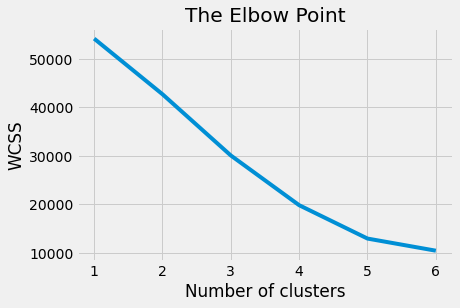

In [39]:
number_clusters = range(1, 7)
plt.style.use("fivethirtyeight")
plt.plot(number_clusters, wcss)
plt.title('The Elbow Point')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
# Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, 7):
    kmeans = KMeans(i)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_coefficients.append(score)

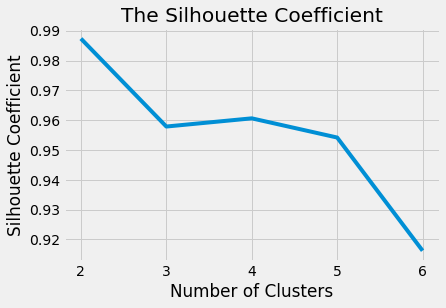

In [41]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 7), silhouette_coefficients)
plt.title('The Silhouette Coefficient')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

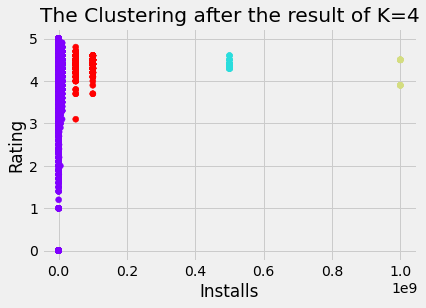

In [42]:
# New Clustering Graph with K=4
kmeans = KMeans(4)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Clustering result
clusters = data.copy()
clusters['cluster_pred'] = kmeans.fit_predict(data)

# plot
#['Installs', 'Reviews']
plt.scatter(clusters['Installs'], clusters['Rating'], c=clusters['cluster_pred'], cmap='rainbow')
plt.title('The Clustering after the result of K=4')
plt.xlabel('Installs')
plt.ylabel('Rating')
plt.show()

In [43]:
cluster_indices = list(kmeans.fit_predict(data))
cluster_indices

data['Group'] = cluster_indices

In [44]:
data['Group'] = data['Group'].apply(lambda x: str(x))
data['Group'] = data['Group'].apply(lambda x: x.replace('0', 'Group1') if '0' == x else x)
data['Group'] = data['Group'].apply(lambda x: x.replace('1', 'Group2') if '1' == x else x)
data['Group'] = data['Group'].apply(lambda x: x.replace('2', 'Group3') if '2' == x else x)
data['Group'] = data['Group'].apply(lambda x: x.replace('3', 'Group4') if '3' == x else x)

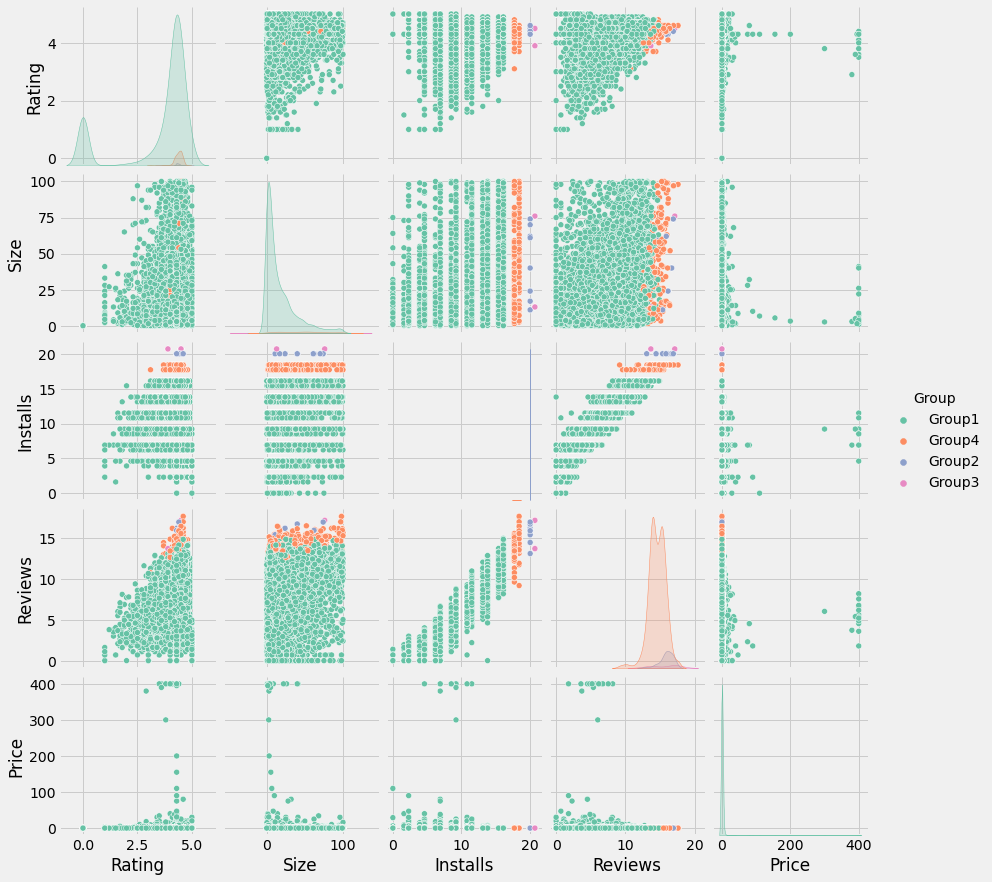

In [45]:
ra = gd['Rating']
s = gd['Size']
i = gd['Installs']
re = gd['Reviews']
c = data['Group']
p = gd['Price']

sns.pairplot(pd.DataFrame(list(zip(ra, s, np.log(i), np.log(re), c, p)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Group', 'Price']),hue='Group', palette="Set2")

In [46]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
num_of_app_in_group = data['Group'].value_counts().sort_values(ascending=True)
data1 = [go.Pie(
        labels = num_of_app_in_group.index,
        values = num_of_app_in_group.values
)]
plotly.offline.iplot(data1, filename='apps_per_group')